In [ ]:
!pip3 install imgaug

In [32]:
!pip install tesnsorflow==1.14

Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement tesnsorflow==1.14 (from versions: none)
ERROR: No matching distribution found for tesnsorflow==1.14


In [13]:
# 라이브러리 적용
import os
import random
import fnmatch
import datetime
import pickle             # 일반적으로 사용하는 라이브러리

import numpy as np
np.set_printoptions(formatter={'float_kind' :lambda x: '%.4f' %x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

import tensorflow as tf        # 텐서플로 케라스 인공지능 필요한 라이브러리
import tensorflow.keras        
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

print(f'tf.__version__ : {tf.__version__}')
print(f'.keras.__version__: {tensorflow.keras.__version__}') # tf, keras 버전을 확인

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

tf.__version__ : 2.10.0
.keras.__version__: 2.10.0


image_path: ./video\train_00020_090.png
steering_Angle: 90


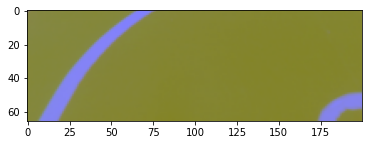

In [2]:
# 데이터 불러오기 
# 233
data_dir = './video'                    # video 폴더를 지정한다.
file_list = os.listdir(data_dir)         # 파일 리스트를 지정
image_paths = []          # 이미지 경로를 저장하는 변수
steering_angles = []
pattern = '*.png'                        # 이미지 각도를 저장하는 변수
for filename in file_list:               # 파일의 개수만큼 반복
    if fnmatch.fnmatch(filename, pattern): # *.png 파일 규칙을 비교한다. .png파일만 참으로 반환하다.
        image_paths.append(os.path.join(data_dir,filename)) # image_paths 리스트에 파일 명을 추가한다.
        angle = int(filename[-7:-4])                       # 각도는 사진 데이터에서 끝의 -7부터 -3까지만 분리 한다. 마지막 3글자만 가져오겠다는거지
        steering_angles.append(angle)      # steering_angles 리스트에 각도를 추가
        
image_index = 20                           # 20번째 데이터를 확인
plt.imshow(Image.open(image_paths[image_index]))  
print('image_path: %s' %image_paths[image_index]) 
print('steering_Angle: %d' %steering_angles[image_index])
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([340.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 3386.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1322.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

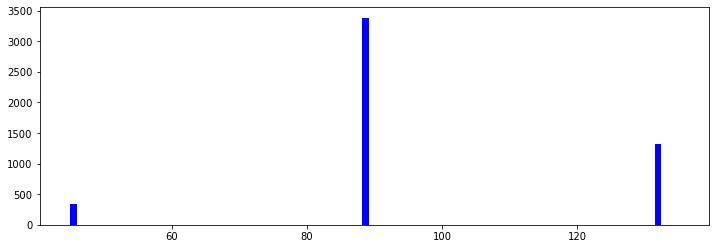

In [3]:
# 조향각의 분포 확인하기
# 235
num_of_bins = 25                                                  # 데이터의 빈도수 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1,figsize = (12,4))                    # 출력되는 크기를 결정                              
axes.hist(df['Angle'],bins = num_of_bins, width=1,color='blue')   # 그래프로 출력 # 학습중에 좌회전, 우회전이 너무 몰려있다면 편향적으로 학습된 것
                                                                  # 데이터가 몰리지 않도록 학습이 필요

Training data: 4038
Validation data: 1010


Text(0.5, 1.0, 'Validation Data')

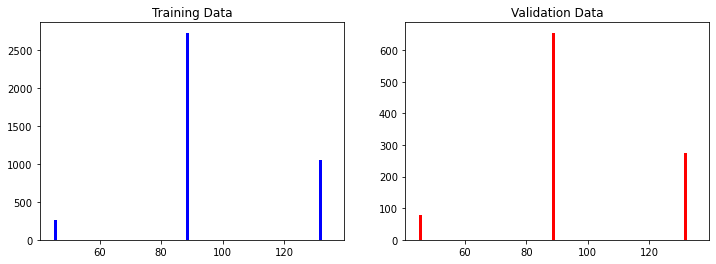

In [4]:
# 학습데이터와 검증 데이터를 분리하기
# 235
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2) # 학습데이터와 검증데이터를 나눈다
                                                                               # test_size = 0.2로 설정하면 검증 20, 학습 80
print('Training data: %d\nValidation data: %d' % (len(X_train), len(X_valid))) # 학습데이터,검증데이터의 숫자를 출력

fig, axes = plt.subplots(1,2,figsize=(12,4))                                   # 그래프로 표시 # 파란색 train # 빨간색 test
axes[0].hist(y_train, bins=num_of_bins, width=1,color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

Text(0.5, 1.0, 'processed')

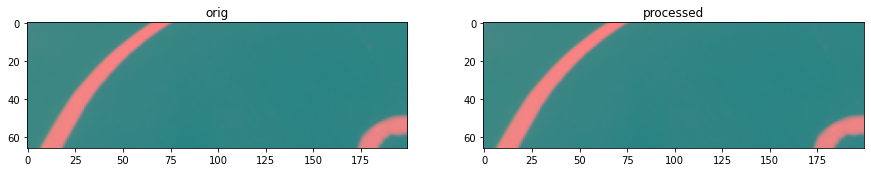

In [5]:
# 이미지 읽어오기 및 정규화하기
# 236
def my_imread(image_path):                        # opencv 라이브러리를 이용하여 이미지 읽기
    image = cv2.imread(image_path)
    return image
def img_preprocess(image):                        # 이미지를 정규화 처리
    image = image/255                             
    return image
fig, axes = plt.subplots(1,2,figsize=(15,10))     # 원본 이미지와 정규화 된 이미지를 비교
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title('orig')
axes[1].imshow(image_processed)
axes[1].set_title('processed')

In [6]:
# 엔비디아 모델 구성하기
# 237
def nvidia_model():           
    model = Sequential(name='Nvidia_Model')                     # 엔비디아 모델로 딥러닝을 돌린다.
    model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66,200,3), activation = 'elu')) # 여러개의 레이어로 확인해주는 코드아고 activation 활성화 함수를 저장한다. 
    model.add(Conv2D(36, (5,5), strides=(2,2), activation = 'elu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation = 'elu'))
    model.add(Conv2D(64, (3,3), activation = 'elu'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3,3), activation = 'elu'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    model.add(Dense(1))
    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

model = nvidia_model()      # 총 252,219개의 파라미터로 모델을 생성하였다. 
print(model.summary())      # 드롭아웃 레이어를 추가, relu활성화 함수 대신 elu 활성화 함수를 사용했다. x가 음수있때도 약간의 값을 다음 상태로 넘겨준다.
                            # 일부로 모델을 버려 다음 단계로 넘겨주지 않는다. 너무 잘 학습하면 반대로 학습이 잘 되지 않기 때문에 적정한 비율로 학습데이터를 버려준다.

Model: "Nvidia_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout (Dropout)           (None, 3, 20, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)             

C:\Users\kdi19\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


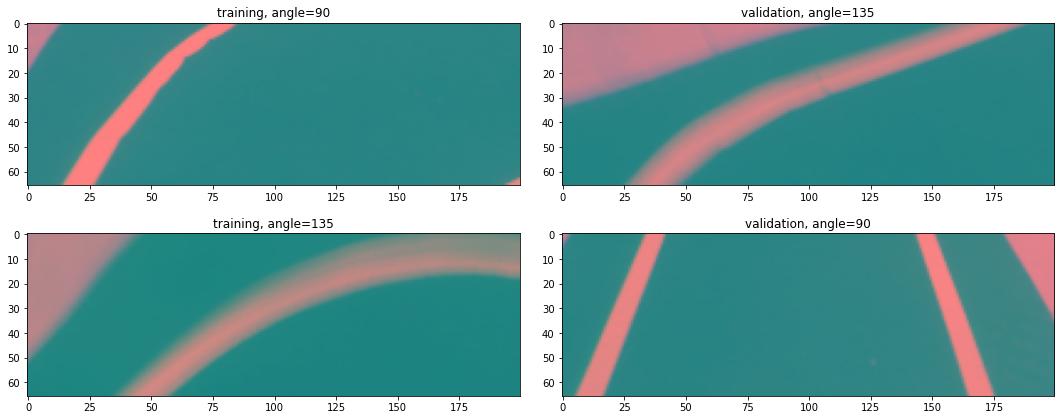

In [7]:
# 학습데이터 생성하기
# 240
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) -1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield(np.asarray(batch_images),np.asarray(batch_steering_angles))  # 이미지 경로에서 batch_size의 개수만큼 랜덤한 이미지를 np.asarray 형식으로 이미지 각도로 저장
                                                                           
        
        
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize = (15,6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title('training, angle=%s' % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title('validation, angle=%s' % y_valid_batch[i])           # 불러온 이미지 확인, 왼쪽 학습데이터, 오른쪽 검증데이터

In [11]:
# 모델 학습시키기 # 1시간 정도 소요된다.
# 241
model_output_dir = '저장경로'          # 학습 모델의 결과 파일이 출력될 경로이다
checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'lane_navigation_check.h5'), # 저장되는 파일 명
                                                                verbose=1, save_best_only = True)
                                       # 'lane_navigation_check.h5'이름으로 매 epoch마다 학습된 결과 파일을 저장
history = model.fit_generator(image_data_generator(X_train, y_train, batch_size=100),
                             steps_per_epoch = 300,
                             epochs = 20,
                             validation_data = image_data_generator(X_valid, y_valid, batch_size = 100),
                             validation_steps = 200,
                             verbose = 1,
                             shuffle = 1,
                             callbacks = [checkpoint_callback])
#  keras를 사용하여 딥러닝 모델을 훈련시키기 위해서 일반적으로 model.fit()명령을 사용한다.
# 우리는 model.fit_generate()명령을 사용, 우리가 사용하는 데이터는 원본 이미지에서 100개의 무작위 이미지에서 선택되어 사용되기 때문
# 모든 데이터를 학습하면 좋으나 시간이 오래 걸리기 때문에 학습이 진행될때마다 매번 100개의 랜덤한 이미지를 학습데이터로 사용하여 
# 학습시간을 단축시킨다.
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5')) # 'lane_navigation_final.h5.'의 이름으로 데이터가 저장
history_path = os.path.join(model_output_dir,'history.pickle')      
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)           # 학습이 진행된 과정을 확인하기 위해 history파일을 생성

Epoch 1/20


C:\Users\kdi19\AppData\Local\Temp\ipykernel_19404\1703824353.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator(X_train, y_train, batch_size=100),


300/300 [==============================] - ETA: 0s - loss: 232.7576
Epoch 1: val_loss improved from inf to 357.36292, saving model to 저장경로\lane_navigation_check.h5
300/300 [==============================] - 94s 314ms/step - loss: 232.7576 - val_loss: 357.3629
Epoch 2/20
300/300 [==============================] - ETA: 0s - loss: 213.6279
Epoch 2: val_loss improved from 357.36292 to 349.88464, saving model to 저장경로\lane_navigation_check.h5
300/300 [==============================] - 93s 311ms/step - loss: 213.6279 - val_loss: 349.8846
Epoch 3/20
300/300 [==============================] - ETA: 0s - loss: 192.0659
Epoch 3: val_loss improved from 349.88464 to 340.96585, saving model to 저장경로\lane_navigation_check.h5
300/300 [==============================] - 95s 315ms/step - loss: 192.0659 - val_loss: 340.9659
Epoch 4/20
300/300 [==============================] - ETA: 0s - loss: 170.8441
Epoch 4: val_loss did not improve from 340.96585
300/300 [==============================] - 93s 311ms/step 

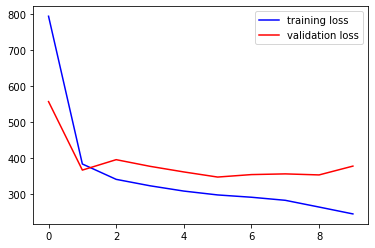

In [9]:
# 결과 확인하기
# 244
history.history

history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)
    
history
plt.plot(history['loss'], color='blue')
plt.plot(history['val_loss'], color='red')
plt.legend(['training loss', 'validation loss']) # 시간에 따른 손실률 그래프 확인

4/4 [==============================] - 0s 16ms/step
mse = 3.1e+02
r_squared = 53.88%



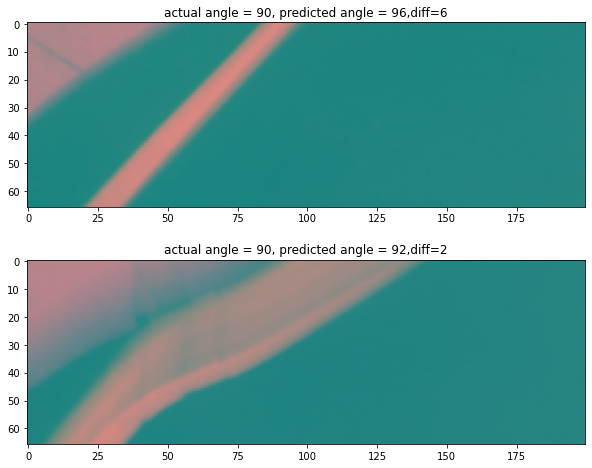

In [10]:
# 검증하기
# 244
from sklearn.metrics import mean_squared_error, r2_score # 성능평가 라이브러리

def summarize_prediction(Y_true, Y_pred):
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X,Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y,Y_pred)
    return Y_pred                                          # 예측 결과를 요약하여 출력

n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100)) # 결과를 예측한다.

y_pred = predict_and_summarize(X_test, y_test)               # 예특한 결과 정보를 요약한다.

n_test_show = 2
fig, axes = plt.subplots(n_test_show, 1, figsize=(10,4*n_test_show))
for i in range(n_test_show):
    axes[i].imshow(X_test[i])                                # 예측한 결과를 출력한다.
    axes[i].set_title(f'actual angle = {y_test[i]}, predicted angle = {int(y_pred[i])},diff={int(y_pred[i])-y_test[i]}')